# 02. Feature Engineering Experiments

Este notebook se enfoca exclusivamente en la creación y análisis de features.
El modelado y evaluación se encuentra en el notebook 03.

## Contenido:
1. Carga de datos
2. Análisis de valores faltantes
3. Transformadores personalizados
4. Pipeline de preprocesamiento
5. Análisis de features creadas
6. Exportar transformadores

## 1. Imports y Configuración

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Imports cargados correctamente')

✅ Imports cargados correctamente


## 2. Carga de Datos

In [73]:
import kagglehub
import os

# Descargar dataset
path = kagglehub.dataset_download("laotse/credit-risk-dataset")
print("Path to dataset files:", path)

files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
full_path = os.path.join(path, csv_file)

df = pd.read_csv(full_path)
print(f"\nDataset cargado: {df.shape[0]:,} filas, {df.shape[1]} columnas")

# Split inicial para desarrollo
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Train set: {X_train.shape}")
print(f"📊 Test set: {X_test.shape}")
print(f"\n🎯 Distribución del target en train:")
print(y_train.value_counts(normalize=True).round(4))

Path to dataset files: C:\Users\aaron\.cache\kagglehub\datasets\laotse\credit-risk-dataset\versions\1

Dataset cargado: 32,581 filas, 12 columnas

📊 Train set: (26064, 11)
📊 Test set: (6517, 11)

🎯 Distribución del target en train:
loan_status
0    0.7818
1    0.2182
Name: proportion, dtype: float64


In [74]:
# Vista previa de los datos
print("Vista previa del dataset:")
display(X_train.head())

print("\nTipos de datos:")
print(X_train.dtypes)

Vista previa del dataset:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15884,25,241875,MORTGAGE,4.0,EDUCATION,A,16000,7.05,0.07,N,4
15138,21,18000,RENT,5.0,PERSONAL,B,1500,12.18,0.08,N,4
7474,25,53000,MORTGAGE,10.0,MEDICAL,B,16000,12.53,0.30,N,2
18212,28,16800,OWN,NaN,MEDICAL,C,5000,13.98,0.30,N,8
6493,25,50000,MORTGAGE,2.0,VENTURE,A,10000,7.90,0.20,N,2



Tipos de datos:
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


## 3. Análisis de Valores Faltantes


📋 Valores faltantes por columna:
                   Missing_Count  Percentage
loan_int_rate               2501    9.595611
person_emp_length            738    2.831492


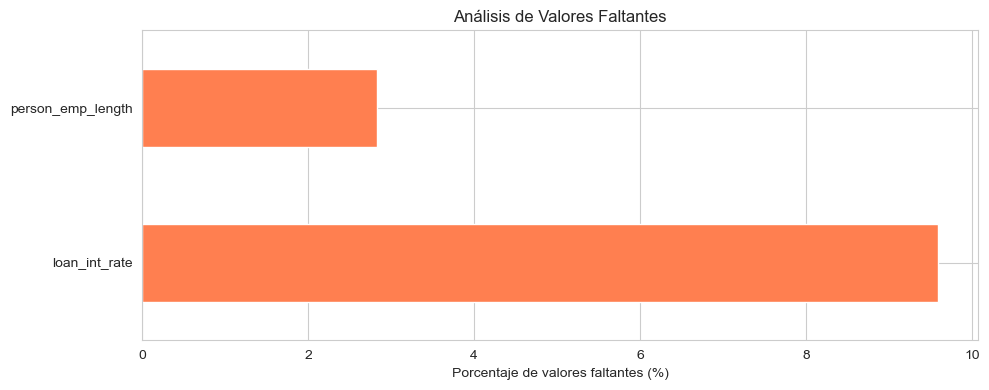

In [75]:
# Analizar valores faltantes
missing = X_train.isnull().sum()
missing_pct = 100 * missing / len(X_train)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)

print("\n📋 Valores faltantes por columna:")
print(missing_df[missing_df['Percentage'] > 0])

# Visualización
if missing_df[missing_df['Percentage'] > 0].shape[0] > 0:
    plt.figure(figsize=(10, 4))
    missing_df[missing_df['Percentage'] > 0]['Percentage'].plot(kind='barh', color='coral')
    plt.xlabel('Porcentaje de valores faltantes (%)')
    plt.title('Análisis de Valores Faltantes')
    plt.tight_layout()
    plt.show()
else:
    print("\n✅ No hay valores faltantes en el dataset")

## 4. Transformadores Personalizados

### 4.1 RareGrouper
Agrupa categorías raras (frecuencia < umbral) en una categoría 'OTHER'

In [76]:
class RareGrouper(BaseEstimator, TransformerMixin):
    """
    Agrupa categorías raras en 'OTHER'.
    
    Parameters:
    -----------
    min_pct : float
        Umbral de frecuencia mínima (default: 0.01 = 1%)
        Categorías con frecuencia menor a este valor se agrupan.
    
    Example:
    --------
    >>> rg = RareGrouper(min_pct=0.05)  # Agrupar categorías con < 5%
    >>> rg.fit_transform(df[['categorical_col']])
    """
    def __init__(self, min_pct=0.01):
        self.min_pct = min_pct
        self.mappings = {}
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.columns:
            freq = X[col].value_counts(normalize=True)
            rare = freq[freq < self.min_pct].index.tolist()
            self.mappings[col] = set(rare)
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, rare_set in self.mappings.items():
            X[col] = X[col].where(~X[col].isin(rare_set), 'OTHER')
        return X

print("✅ RareGrouper definido")

✅ RareGrouper definido


In [77]:
# Test del RareGrouper
test_df = pd.DataFrame({
    'category': ['A'] * 100 + ['B'] * 50 + ['C'] * 5 + ['D'] * 3
})

print("\n🧪 Test de RareGrouper:")
print("\nOriginal:")
print(test_df['category'].value_counts())

rg = RareGrouper(min_pct=0.05)  # 5%
rg.fit(test_df)
transformed = rg.transform(test_df)

print("\nTransformado (min_pct=0.05):")
print(transformed['category'].value_counts())
print("\n✅ Categorías con < 5% agrupadas en 'OTHER'")


🧪 Test de RareGrouper:

Original:
category
A    100
B     50
C      5
D      3
Name: count, dtype: int64

Transformado (min_pct=0.05):
category
A        100
B         50
OTHER      8
Name: count, dtype: int64

✅ Categorías con < 5% agrupadas en 'OTHER'


### 4.2 FeatureCreator
Crea nuevas features derivadas de las existentes

In [78]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    """
    Crea features derivadas para el modelo de riesgo crediticio.
    
    Features creadas:
    ----------------
    1. is_emp_length_missing: Flag binario para missing values en employment length
    2. is_loan_int_rate_missing: Flag binario para missing values en interest rate
    3. log_person_income: Transformación logarítmica del ingreso
    4. log_loan_amnt: Transformación logarítmica del monto del préstamo
    5. income_to_loan: Ratio ingreso/monto del préstamo
    6. cred_hist_ratio: Ratio historial crediticio/edad
    7. age_bucket: Categorización de edad en bins
    8. loan_amt_rate_inter: Interacción monto × tasa de interés
    
    Parameters:
    -----------
    age_bins : list
        Límites de bins para categorizar edad (default: [18, 25, 35, 50, 100])
    """
    def __init__(self, age_bins=[18, 25, 35, 50, 100]):
        self.age_bins = age_bins
        self.income_q01 = None
        self.income_q99 = None
        self.median_loan_rate = None
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # Guardar estadísticas del training set
        self.income_q01 = X['person_income'].quantile(0.01)
        self.income_q99 = X['person_income'].quantile(0.99)
        self.median_loan_rate = X['loan_int_rate'].median()
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        
        # 1. Flags de missing values
        X['is_emp_length_missing'] = X['person_emp_length'].isnull().astype(int)
        X['is_loan_int_rate_missing'] = X['loan_int_rate'].isnull().astype(int)
        
        # 2. Transformaciones logarítmicas (log1p maneja zeros)
        X['log_person_income'] = np.log1p(X['person_income'].fillna(0))
        X['log_loan_amnt'] = np.log1p(X['loan_amnt'].fillna(0))
        
        # 3. Features de ratio
        X['income_to_loan'] = X['person_income'] / (1 + X['loan_amnt'].fillna(0))
        X['cred_hist_ratio'] = X['cb_person_cred_hist_length'] / (1 + X['person_age'].fillna(0))
        
        # 4. Age buckets (como string para OneHotEncoding posterior)
        X['age_bucket'] = pd.cut(
            X['person_age'].fillna(-1),
            bins=self.age_bins,
            labels=False,
            include_lowest=True
        ).astype('Int64').astype(str)
        
        # 5. Feature de interacción
        X['loan_amt_rate_inter'] = X['loan_amnt'] * X['loan_int_rate'].fillna(self.median_loan_rate)
        
        # 6. Clipping de outliers en income (usando quantiles del train set)
        X['person_income'] = X['person_income'].clip(
            lower=self.income_q01,
            upper=self.income_q99
        )
        
        return X

print("✅ FeatureCreator definido")

✅ FeatureCreator definido


In [79]:
# Test del FeatureCreator
print("\n🧪 Test de FeatureCreator:")
fc = FeatureCreator()
fc.fit(X_train)
X_train_with_features = fc.transform(X_train.head(10))

# Mostrar nuevas features creadas
new_cols = set(X_train_with_features.columns) - set(X_train.columns)
print(f"\n✅ Nuevas features creadas ({len(new_cols)}):")
for col in sorted(new_cols):
    print(f"  • {col}")

print(f"\nColumnas totales: {len(X_train.columns)} → {len(X_train_with_features.columns)}")


🧪 Test de FeatureCreator:

✅ Nuevas features creadas (8):
  • age_bucket
  • cred_hist_ratio
  • income_to_loan
  • is_emp_length_missing
  • is_loan_int_rate_missing
  • loan_amt_rate_inter
  • log_loan_amnt
  • log_person_income

Columnas totales: 11 → 19


## 5. Pipeline Completo de Preprocesamiento

In [80]:
# Definición de columnas (DESPUÉS de FeatureCreator)
numeric_cols = [
    # Originales
    'person_income', 'person_emp_length', 'person_age', 'loan_amnt',
    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
    # Creadas
    'log_person_income', 'log_loan_amnt', 'income_to_loan', 'cred_hist_ratio',
    'loan_amt_rate_inter', 'is_emp_length_missing', 'is_loan_int_rate_missing'
]

ordinal_cols = ['loan_grade']  # A < B < C < D < E < F < G
binary_cols = ['cb_person_default_on_file']  # Y/N
nominal_cols = ['person_home_ownership', 'loan_intent', 'age_bucket']

print(f"\n📊 Distribución de tipos de columnas:")
print(f"  • Numéricas: {len(numeric_cols)}")
print(f"  • Ordinales: {len(ordinal_cols)}")
print(f"  • Binarias: {len(binary_cols)}")
print(f"  • Nominales: {len(nominal_cols)}")
print(f"  • Total: {len(numeric_cols) + len(ordinal_cols) + len(binary_cols) + len(nominal_cols)}")


📊 Distribución de tipos de columnas:
  • Numéricas: 14
  • Ordinales: 1
  • Binarias: 1
  • Nominales: 3
  • Total: 19


In [81]:
# 1. Transformador numérico: Imputación + Escalado Robusto
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())  # Robusto a outliers (usa mediana e IQR)
])

# 2. Transformador ordinal: Orden específico de loan grades
grade_categories = [['A', 'B', 'C', 'D', 'E', 'F', 'G']]
ordinal_transformer = OrdinalEncoder(
    categories=grade_categories,
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

# 3. Transformador binario: Y/N → 1/0
def binary_mapping(df):
    return pd.DataFrame(df).replace({'Y': 1, 'N': 0}).astype(float)

binary_transformer = FunctionTransformer(
    binary_mapping,
    validate=False
)

# 4. Transformador nominal: Agrupación de raros + One-Hot Encoding
nominal_transformer = Pipeline(steps=[
    ('rare', RareGrouper(min_pct=0.01)),  # Agrupar categorías con < 1%
    ('onehot', OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=True  # Usar sparse matrix para eficiencia
    ))
])

print("✅ Transformadores individuales definidos")

✅ Transformadores individuales definidos


In [82]:
# ColumnTransformer que combina todos los transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('bin', binary_transformer, binary_cols),
        ('nom', nominal_transformer, nominal_cols),
    ],
    remainder='drop',  # Descartar columnas no especificadas
    verbose_feature_names_out=False
)

print("✅ ColumnTransformer (preprocessor) definido")

✅ ColumnTransformer (preprocessor) definido


In [83]:
# Pipeline completo: Feature Creation → Preprocessing
# NOTA: El modelo se añadirá en el notebook 03
feature_pipeline = Pipeline(steps=[
    ('feature_creation', FeatureCreator()),
    ('preprocessing', preprocessor)
])

print("\n✅ Pipeline completo de feature engineering:")
print(feature_pipeline)


✅ Pipeline completo de feature engineering:
Pipeline(steps=[('feature_creation', FeatureCreator()),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['person_income',
                                                   'person_emp_length',
                                                   'person_age', 'loan_amnt',
                                                   'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length',
                        

### 5.1 Test del Pipeline

In [84]:
# Fit y transform del pipeline
print("\n🔧 Entrenando pipeline de features...")
feature_pipeline.fit(X_train)

# Transform en train y test
X_train_transformed = feature_pipeline.transform(X_train)
X_test_transformed = feature_pipeline.transform(X_test)

print(f"\n📊 Resultados de la transformación:")
print(f"  Train: {X_train.shape} → {X_train_transformed.shape}")
print(f"  Test: {X_test.shape} → {X_test_transformed.shape}")

# Obtener nombres de features finales
try:
    feature_names = feature_pipeline.named_steps['preprocessing'].get_feature_names_out()
    print(f"\n  Total features después del pipeline: {len(feature_names)}")
except:
    print("\n  (No se pudieron obtener nombres de features)")


🔧 Entrenando pipeline de features...

📊 Resultados de la transformación:
  Train: (26064, 11) → (26064, 30)
  Test: (6517, 11) → (6517, 30)

  (No se pudieron obtener nombres de features)


## 6. Análisis de Features Creadas

In [85]:
# Aplicar solo FeatureCreator para analizar las features
fc_analysis = FeatureCreator()
X_with_features = fc_analysis.fit_transform(X_train)

# Features creadas (excluyendo las modificadas)
created_features = [
    'log_person_income', 'log_loan_amnt', 'income_to_loan',
    'cred_hist_ratio', 'loan_amt_rate_inter',
    'is_emp_length_missing', 'is_loan_int_rate_missing', 'age_bucket'
]

print("\n📈 Estadísticas de features creadas:")
print(X_with_features[created_features].describe().round(4))


📈 Estadísticas de features creadas:
       log_person_income  log_loan_amnt  income_to_loan  cred_hist_ratio  \
count         26064.0000     26064.0000      26064.0000       26064.0000   
mean             10.9242         8.9402          9.7550           0.1879   
std               0.5667         0.7108         13.8241           0.0913   
min               8.2943         6.2166          1.2047           0.0138   
25%              10.5570         8.5174          4.3745           0.1200   
50%              10.9151         8.9873          6.7492           0.1667   
75%              11.2772         9.3927         11.1413           0.2500   
max              15.6073        10.4631       1199.7600           0.5769   

       loan_amt_rate_inter  is_emp_length_missing  is_loan_int_rate_missing  
count           26064.0000             26064.0000                26064.0000  
mean           107914.3382                 0.0283                    0.0960  
std             85551.9606                 0

### 6.1 Distribuciones de Features Creadas

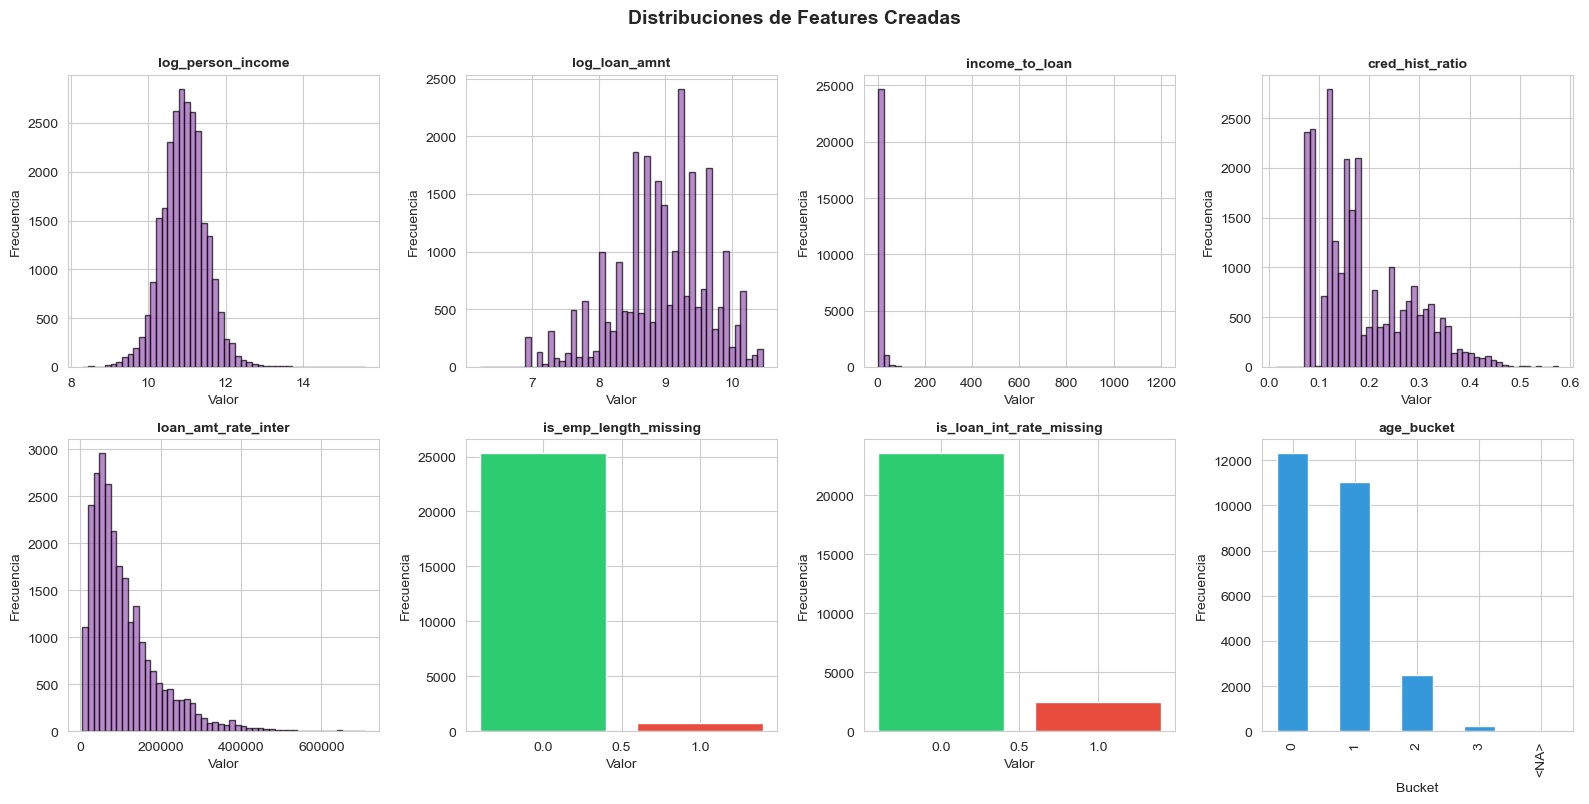

In [86]:
# Visualizar distribuciones
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, feat in enumerate(created_features):
    if feat.startswith('is_'):
        # Para flags binarios, usar bar plot
        counts = X_with_features[feat].value_counts().sort_index()
        axes[idx].bar(counts.index, counts.values, color=['#2ecc71', '#e74c3c'])
        axes[idx].set_title(feat, fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Valor')
        axes[idx].set_ylabel('Frecuencia')
    elif feat == 'age_bucket':
        # Para buckets categóricos
        X_with_features[feat].value_counts().sort_index().plot(kind='bar', ax=axes[idx], color='#3498db')
        axes[idx].set_title(feat, fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Bucket')
        axes[idx].set_ylabel('Frecuencia')
    else:
        # Para features continuas, usar histogram
        axes[idx].hist(X_with_features[feat].dropna(), bins=50, edgecolor='black', alpha=0.7, color='#9b59b6')
        axes[idx].set_title(feat, fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Valor')
        axes[idx].set_ylabel('Frecuencia')

plt.suptitle('Distribuciones de Features Creadas', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 6.2 Correlación con el Target


📊 Correlación de features creadas con loan_status:
loan_amt_rate_inter    0.2064
log_loan_amnt          0.0760
cred_hist_ratio       -0.0163
income_to_loan        -0.1282
log_person_income     -0.2839
Name: loan_status, dtype: float64


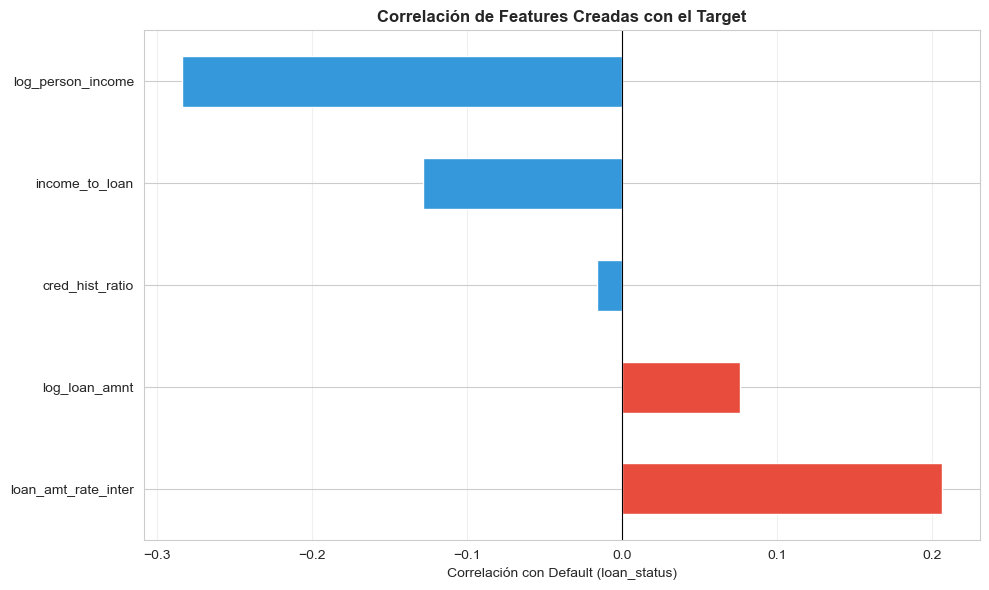

In [87]:
# Añadir target para análisis
X_with_target = X_with_features.copy()
X_with_target['loan_status'] = y_train.values

# Features numéricas creadas (sin flags binarios y age_bucket)
numeric_created = ['log_person_income', 'log_loan_amnt', 'income_to_loan',
                   'cred_hist_ratio', 'loan_amt_rate_inter']

# Calcular correlaciones
correlations = X_with_target[numeric_created + ['loan_status']].corr()['loan_status'].drop('loan_status')
correlations = correlations.sort_values(ascending=False)

print("\n📊 Correlación de features creadas con loan_status:")
print(correlations.round(4))

# Visualización
plt.figure(figsize=(10, 6))
colors = ['#e74c3c' if x > 0 else '#3498db' for x in correlations]
correlations.plot(kind='barh', color=colors)
plt.xlabel('Correlación con Default (loan_status)')
plt.title('Correlación de Features Creadas con el Target', fontweight='bold')
plt.axvline(0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 6.3 Análisis de Flags de Missing Values


🚩 Análisis de flags de missing values:

1. Employment Length Missing:
                       Default_Rate  Count
is_emp_length_missing                     
0                             21.52  25326
1                             31.98    738

2. Loan Interest Rate Missing:
                          Default_Rate  Count
is_loan_int_rate_missing                     
0                                21.88  23563
1                                21.23   2501


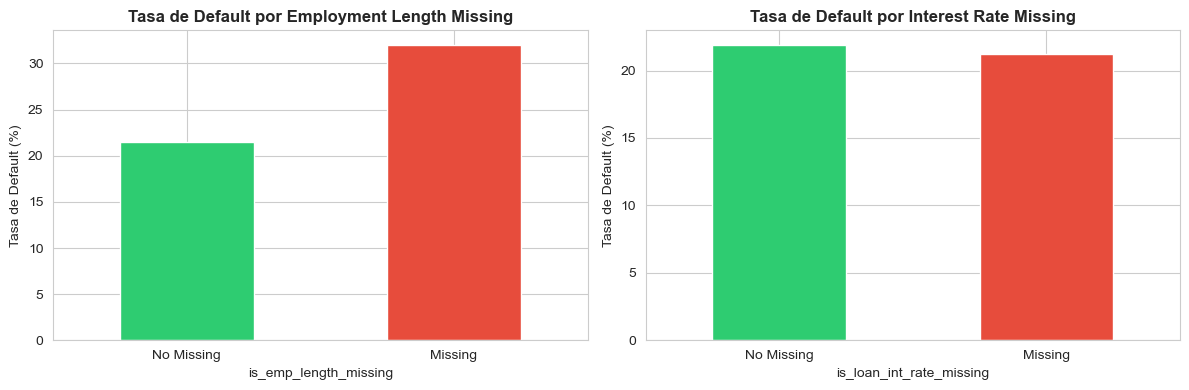

In [88]:
# Tasas de default para cada flag
print("\n🚩 Análisis de flags de missing values:")
print("\n1. Employment Length Missing:")
emp_flag_default = X_with_target.groupby('is_emp_length_missing')['loan_status'].agg(['mean', 'count'])
emp_flag_default.columns = ['Default_Rate', 'Count']
emp_flag_default['Default_Rate'] = (emp_flag_default['Default_Rate'] * 100).round(2)
print(emp_flag_default)

print("\n2. Loan Interest Rate Missing:")
rate_flag_default = X_with_target.groupby('is_loan_int_rate_missing')['loan_status'].agg(['mean', 'count'])
rate_flag_default.columns = ['Default_Rate', 'Count']
rate_flag_default['Default_Rate'] = (rate_flag_default['Default_Rate'] * 100).round(2)
print(rate_flag_default)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Employment length missing
emp_flag_default['Default_Rate'].plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Tasa de Default por Employment Length Missing', fontweight='bold')
axes[0].set_xlabel('is_emp_length_missing')
axes[0].set_ylabel('Tasa de Default (%)')
axes[0].set_xticklabels(['No Missing', 'Missing'], rotation=0)

# Interest rate missing
rate_flag_default['Default_Rate'].plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Tasa de Default por Interest Rate Missing', fontweight='bold')
axes[1].set_xlabel('is_loan_int_rate_missing')
axes[1].set_ylabel('Tasa de Default (%)')
axes[1].set_xticklabels(['No Missing', 'Missing'], rotation=0)

plt.tight_layout()
plt.show()

## 7. Exportar Pipeline y Transformadores

Guardamos el pipeline para usarlo en los siguientes notebooks

In [89]:
import joblib

# Guardar el pipeline de features
joblib.dump(feature_pipeline, 'feature_engineering_pipeline.pkl')
print("\n✅ Pipeline guardado como 'feature_engineering_pipeline.pkl'")

# Guardar también información de columnas
column_info = {
    'numeric_cols': numeric_cols,
    'ordinal_cols': ordinal_cols,
    'binary_cols': binary_cols,
    'nominal_cols': nominal_cols,
    'created_features': created_features,
    'age_bins': [18, 25, 35, 50, 100],
    'grade_categories': grade_categories
}

joblib.dump(column_info, 'feature_engineering_config.pkl')
print("✅ Configuración guardada como 'feature_engineering_config.pkl'")

# Guardar datos transformados para el siguiente notebook
train_data = {
    'X_train_transformed': X_train_transformed,
    'y_train': y_train,
    'X_test_transformed': X_test_transformed,
    'y_test': y_test
}

joblib.dump(train_data, 'transformed_data.pkl')
print("✅ Datos transformados guardados como 'transformed_data.pkl'")

print("\n" + "="*60)
print("🎉 FEATURE ENGINEERING COMPLETADO")
print("="*60)
print("\nArchivos generados:")
print("  1. feature_engineering_pipeline.pkl")
print("  2. feature_engineering_config.pkl")
print("  3. transformed_data.pkl")
print("\nPróximo paso: Notebook 03 - Model Prototyping and Tuning")


✅ Pipeline guardado como 'feature_engineering_pipeline.pkl'
✅ Configuración guardada como 'feature_engineering_config.pkl'
✅ Datos transformados guardados como 'transformed_data.pkl'

🎉 FEATURE ENGINEERING COMPLETADO

Archivos generados:
  1. feature_engineering_pipeline.pkl
  2. feature_engineering_config.pkl
  3. transformed_data.pkl

Próximo paso: Notebook 03 - Model Prototyping and Tuning
